# Preprocessing audi file into 32 * 32 melspectrogram

The goal of the notebook is to save a dataframe containing as id the name of the file and as features a flattened melspectogram using: 32 frames * 32 frequency bins = 1024 features. 

## The preprocessing described in DCASE 2021 Task2: 

1) They use the mel spectrogram using a framesize of 64ms and a hopsize of 50%.

2) After obtaining the mel-spectrogram they concat each 64 consecutives frames with a frame_size of 8 frames

3) The result for one audio: is 32 samples containing each the 64 consecutives data frames * 128 mel freq bins

Not confirmed: Looking at it, it seems they get one of the 32 samples of one audio, to flattens it to have 64 * 128 = 8192 feature line to feed into their model. Or they Flatten for an audio the whole sample: making it an input layer of 32 * 8192  = 262144 features

In [2]:
#Nb of samples in one audio sample
AUDIO_SAMPLE_RATE = 16000
AUDIO_TIME_S = 10
nb_of_frames_audo_original = AUDIO_TIME_S * AUDIO_SAMPLE_RATE
print('nb of frames in audio sample : ' + str(nb_of_frames_audo_original) + '\n')

#Windowsize and hopsize used in frames nb:
windowsize = (64 / 1000) * 16000 #(1s in ms / windowsizeinms) * sample rates of audio
hopsize = windowsize / 2
print('window_size used for melspec : ' + str(windowsize))
print('hop_size used for melspec : ' + str(hopsize)  + '\n')


#Nb of samples after the mel spectrogram transformation:
melspec_frames_from_framesize_alone = nb_of_frames_audo_original / windowsize
melsmpec_frames_total = melspec_frames_from_framesize_alone * 2
print('nb of total frames of the mel spectro : ' + str(melsmpec_frames_total)  + '\n')

nb of frames in audio sample : 160000

window_size used for melspec : 1024.0
hop_size used for melspec : 512.0

nb of total frames of the mel spectro : 312.5



### Let's just simulate the way the concatenante and check whether our story match:

In [57]:
for i in range(32):
    print('Itération i : ' + str(i) + ' nb of frames used : ' + str((i*8) + 64))

Itération i : 0 nb of frames used : 64
Itération i : 1 nb of frames used : 72
Itération i : 2 nb of frames used : 80
Itération i : 3 nb of frames used : 88
Itération i : 4 nb of frames used : 96
Itération i : 5 nb of frames used : 104
Itération i : 6 nb of frames used : 112
Itération i : 7 nb of frames used : 120
Itération i : 8 nb of frames used : 128
Itération i : 9 nb of frames used : 136
Itération i : 10 nb of frames used : 144
Itération i : 11 nb of frames used : 152
Itération i : 12 nb of frames used : 160
Itération i : 13 nb of frames used : 168
Itération i : 14 nb of frames used : 176
Itération i : 15 nb of frames used : 184
Itération i : 16 nb of frames used : 192
Itération i : 17 nb of frames used : 200
Itération i : 18 nb of frames used : 208
Itération i : 19 nb of frames used : 216
Itération i : 20 nb of frames used : 224
Itération i : 21 nb of frames used : 232
Itération i : 22 nb of frames used : 240
Itération i : 23 nb of frames used : 248
Itération i : 24 nb of frames u

It match! The last frame is certainly not used.

## The preprocessing that is proposed here

We will do amost exactly the same for 1) and 2) and for 3).

1) We will only use 32 bins filters and use a a log spectogram transformation, not a log mel.

1) bis we will also use the mel spectogram since stft func of librosa doesn't directly bin the frequencies together
      
2) The concatenation of 64 consecutive frames with a hopsize of 8 frames will be replaced by a sum of 64 consecutives frames with a hopsize of 8 frames. 

3) The result is for each audio sample: 32 frames of 64 concatenated frames and 32 spec bins

The goal is to feed for each audio a flatten input array of 32*32 = 1024 features. 
Of course we can speculate that this model won't result anything as it lacks a lot of resolutions!

In [12]:
#Let's first import the module that we will need
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

### Get df with file path

In [4]:
PATH_TRAINING_DATASET = './Datasets/Training/'
PATH_ADDITIONNAL_DATASET = './Datasets/Additionnal/'

#Get list of files in train and test directory
def get_df_files(type_machinery):


    path_train_folder = PATH_TRAINING_DATASET + 'dev_' + type_machinery + '/' + type_machinery + '/train/'
    path_test_folder = PATH_TRAINING_DATASET + 'dev_' + type_machinery + '/' + type_machinery + '/test/'

    train_files = [f for f in os.listdir(path_train_folder)]
    test_files = [f for f in os.listdir(path_test_folder)]

    #Get list of dictionnary for creating DataFrame
    list_dict_file = []

    #Loop through filenames
    for filename in train_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_train_folder + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:]).split('.wav')[0]
        })

    #Loop through filenames
    for filename in test_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_test_folder + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:]).split('.wav')[0]
        })

    #Get file dataframe
    df_files = pd.DataFrame(list_dict_file)
    
    return df_files


### First let's visualize step by step the preprocess with one audio file

Let's take an audio from the valve machinery dataset

In [5]:
#get valve df
df = get_df_files('valve')
df.head()

,filepath,filename,section,domain_env,dir,sound_type,id,suffix
0,./Datasets/Training/dev_valve/valve/train/sect...,section_00_source_train_normal_0000_pat_00.wav,0,source,train,normal,0000,pat_00
1,./Datasets/Training/dev_valve/valve/train/sect...,section_00_source_train_normal_0001_pat_00.wav,0,source,train,normal,0001,pat_00
2,./Datasets/Training/dev_valve/valve/train/sect...,section_00_source_train_normal_0002_pat_01.wav,0,source,train,normal,0002,pat_01
3,./Datasets/Training/dev_valve/valve/train/sect...,section_00_source_train_normal_0003_pat_00.wav,0,source,train,normal,0003,pat_00
4,./Datasets/Training/dev_valve/valve/train/sect...,section_00_source_train_normal_0004_pat_01.wav,0,source,train,normal,0004,pat_01


1) Get the audio and its spectrogram

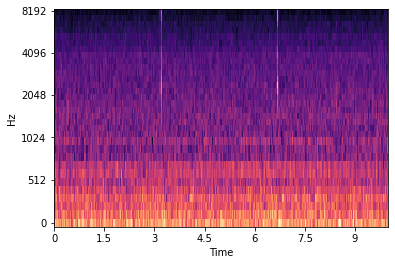

In [19]:
#Get audio array
audio_sample_path = df.loc[0,'filepath']
audio_array, sr = librosa.load(audio_sample_path, sr=None)

#Get mel spectogram
FRAME_SIZE = 1024
HOP_LENGTH = 512
melspectogram = librosa.feature.melspectrogram(
    y=audio_array, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_SIZE, n_mels=32
)
melspectogram = librosa.power_to_db(melspectogram, ref=np.max)
librosa.display.specshow(melspectogram, sr=16000, x_axis='time', y_axis='mel', cmap='magma')

In [21]:
print('nb of mel bins frequency : ' + str(melspectogram.shape[0]))
print('nb of frames : ' + str(melspectogram.shape[1]))

nb of mel bins frequency : 32
nb of frames : 313


2) Sum of the 64 consecutive frames with a hopsize of 8 frames:

In [54]:
summed_melspectrograms = melspectogram[:,:64].sum(axis=1)
for i in range(1,32):
    j = i*8
    summed_melspectrograms = np.concatenate((summed_melspectrograms, melspectogram[:,j:64+j].sum(axis=1)))

In [58]:
print('Shape of the feature row : ' + str(summed_melspectrograms.shape))

Shape of the feature row : (1024,)


### Function of preprocessing of a machinery dataset

In [81]:
def preprocess_and_store_features(type_machinery):
    
    #Constants
    PATH_FEATURES_FOLDER = './Features/'
    PATH_MELSPEC_32_32_FOLDER = PATH_FEATURES_FOLDER + 'melspec_32_32/'
    FRAME_SIZE = 1024
    HOP_LENGTH = 512

    #Check or create folders
    if not os.path.exists(PATH_FEATURES_FOLDER):
        os.makedirs(PATH_FEATURES_FOLDER)

    if not os.path.exists(PATH_MELSPEC_32_32_FOLDER):
        os.makedirs(PATH_MELSPEC_32_32_FOLDER)

    path_machinery_folder = PATH_MELSPEC_32_32_FOLDER + type_machinery + '/'
    if not os.path.exists(path_machinery_folder):
        os.makedirs(path_machinery_folder)
        
    #Get dataframes of files
    df = get_df_files('valve')
    
    #Loop through dataframes
    for idx, row in df.iterrows():

        #Get audio array
        audio_sample_path = row['filepath']
        audio_array, sr = librosa.load(audio_sample_path, sr=None)

        #Get mel spectogram
        melspectogram = librosa.feature.melspectrogram(
            y=audio_array, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_SIZE, n_mels=32
        )
        melspectogram = librosa.power_to_db(melspectogram, ref=np.max)

        #Sum consecutives 64 frames with a 8 frames hopsize
        summed_melspectrograms = melspectogram[:,:64].sum(axis=1)
        for i in range(1,32):
            j = i*8
            summed_melspectrograms = np.concatenate((summed_melspectrograms, melspectogram[:,j:64+j].sum(axis=1)))

        #Save feature
        filename = path_machinery_folder + row['filename'].split('.wav')[0] + '.csv'
        np.savetxt(filename, summed_melspectrograms.reshape(1,1024), delimiter=";")

        

### Let's start with the valves :

In [80]:
preprocess_and_store_features('valve')

-1324918.8
-1486378.9
-1464594.8
-1695930.8
-1189962.0
-1511080.8
-1464040.0
-1768538.9
-2155401.5
-1549410.5
-1982020.4
-1487782.1
-1454176.2
-1438146.5
-1551954.5
-1446367.1
-1561461.2
-1487643.5
-1509004.4
-1836039.6
-1205359.5
-1564265.8
-1540870.4
-1795911.0
-1510570.0
-1487524.4
-1020589.0
-1818430.0
-1566412.8
-1511508.4
-2280122.5
-1663148.2
-1393904.1
-1689681.2
-1469084.0
-1556203.5
-1527713.0
-1473021.2
-1452273.2
-2297354.2
-1816621.0
-1479130.2
-2153554.0
-1307808.9
-1753213.6
-1476908.0
-1483839.9
-1583624.0
-1201027.5
-1368811.0
-1503379.6
-1395511.0
-1806577.5
-1540860.6
-1556395.5
-1575815.0
-2066074.5
-1628050.8
-1568431.0
-1358520.6
-1421907.1
-1728802.1
-1523394.2
-1422950.8
-1382268.5
-1524040.0
-1540355.5
-1466038.9
-1263074.8
-2025903.5
-1210122.6
-1953301.5
-1335795.9
-1772922.5
-1868364.1
-1505387.2
-1637041.4
-1429731.4
-2106773.0
-1718667.6
-1551296.5
-1681472.2
-1482607.0
-1570778.5
-2277729.8
-1461052.5
-1086198.1
-1484375.4
-1588169.1
-1659478.2
-1457447.8

-1692530.2
-1475392.6
-1523536.2
-1268650.2
-1703959.0
-1036602.6
-1664028.8
-1595408.6
-1313112.8
-1246016.8
-1596924.9
-1380851.2
-1434354.2
-1417696.0
-1341778.5
-1234727.5
-2018316.2
-1495076.2
-1659894.5
-1495229.2
-1494776.4
-1562959.8
-1387428.1
-1610350.2
-1433141.5
-1629357.2
-1704119.8
-1556388.5
-1842928.2
-1633931.5
-1414434.4
-1549490.9
-1498051.8
-1606454.4
-1676839.8
-1576300.1
-1455520.0
-1648577.5
-1837841.0
-1347907.0
-2447589.8
-1548139.6
-1474767.0
-1540457.5
-1410825.8
-1683016.8
-1485359.5
-1540833.2
-1102421.2
-1665366.4
-1172366.5
-1397529.5
-2019997.8
-1159935.0
-1415284.5
-1243558.6
-1800727.9
-1741138.0
-1256782.5
-1588256.0
-1610666.9
-1569334.2
-1412854.4
-1545011.6
-1570635.0
-1570493.2
-1519229.1
-1490956.2
-1548645.1
-1640660.6
-1331446.5
-1598677.2
-1464325.2
-2047625.6
-1555786.6
-1501016.4
-1445148.9
-1025255.5
-1656228.1
-1607402.4
-1389093.0
-1597440.2
-1426776.1
-1604508.5
-1621276.0
-1533199.8
-1609354.4
-1514382.2
-1481303.0
-1531658.2
-1577322.1

-1545982.8
-1421039.8
-1976510.0
-1368399.6
-1736227.4
-1541932.2
-1437934.5
-1554946.2
-1213653.2
-1539016.8
-1646628.8
-1555247.8
-1654907.1
-1659875.1
-1485491.9
-1436083.8
-1114955.2
-1573366.2
-1566140.5
-1539015.0
-1581070.8
-939296.1
-1521632.6
-980849.4
-1594743.5
-1535308.5
-1437634.4
-989072.8
-1441522.0
-1173159.8
-1523700.8
-1519782.6
-1117549.5
-1592790.0
-1882580.8
-1662571.8
-1986427.4
-1612224.8
-1241169.1
-2058524.8
-1481461.5
-828691.5
-1450369.9
-1603115.4
-1607564.2
-1300274.2
-1417492.4
-1108665.5
-1068251.5
-1533152.6
-1755015.0
-1394825.8
-1538034.0
-1702816.0
-1538161.5
-1333738.2
-1816277.8
-1479735.2
-1759384.5
-1529567.8
-2142398.5
-1442128.2
-1283424.8
-2140247.8
-1567245.8
-1428284.0
-2138368.5
-1503117.4
-1466914.2
-1554220.4
-1483526.8
-1743575.6
-1330842.6
-1503770.2
-1520464.8
-1720796.5
-1483651.2
-1531589.5
-1558318.9
-1117281.5
-1561462.2
-1791994.6
-1516636.4
-1157657.0
-1153672.6
-1653965.0
-1632572.1
-1255085.9
-1590807.6
-1467050.9
-1744324.8
-17

-1534094.0
-1521028.8
-1649167.4
-1384003.8
-1549186.5
-1526271.6
-1431171.8
-1558337.0
-1716359.8
-1646319.8
-1900635.2
-1292791.0
-1468943.2
-1192443.5
-1564411.1
-1585078.2
-1519310.6
-1722991.8
-1528225.8
-1403072.2
-1499784.9
-1472572.8
-1604171.0
-1525290.2
-1532467.8
-1656747.0
-1569652.2
-1460875.0
-2205123.0
-1563961.8
-1413350.5
-1529779.9
-1632591.0
-1793568.6
-1515482.4
-1038008.1
-1223711.5
-1479013.9
-1186494.5
-1454878.0
-1616756.8
-1414253.4
-1578307.5
-1437600.4
-1480442.0
-1740808.8
-1610487.5
-1785144.8
-1216229.6
-1428390.8
-1612348.0
-1434182.1
-1465847.0
-1815043.5
-1616931.9
-1562874.6
-1441702.6
-1493586.5
-1546177.1
-1583276.2
-1653955.2
-1308198.5
-1427480.6
-1556006.0
-1342252.8
-2146771.8
-1464975.5
-1587082.2
-1554072.9
-1429156.8
-1269021.9
-1509157.0
-1806844.6
-1554367.2
-898847.9
-1267187.9
-1541215.8
-1543012.2
-1613886.5
-1509342.2
-1492801.2
-1339706.0
-1975896.5
-1450250.8
-1534853.9
-1797857.5
-1620564.0
-1351337.9
-1664542.4
-1405120.9
-1532056.2


-1122016.6
-1406319.8
-1516397.2
-1499117.8
-1562589.6
-1408538.5
-1520296.8
-1673824.0
-1449744.2
-1428112.2
-1529568.2
-2112959.0
-1532271.2
-1744125.5
-1621913.8
-1431535.8
-1619044.8
-1479512.5
-943034.75
-1442730.4
-2177331.0
-1486688.5
-1044882.1
-1527132.4
-1409504.0
-1633998.4
-1709572.9
-2143151.5
-1467979.4
-1756354.8
-1352839.2
-1720497.4
-1454191.0
-969858.0
-1393113.8
-1529045.1
-1734146.2
-1652482.8
-1677953.9
-1510092.5
-1543786.8
-1447565.2
-1503175.9
-1169553.5
-1456944.0
-1692869.2
-1797352.6
-1802589.1
-1671798.5
-1290842.9
-1056129.8
-1585454.4
-1643150.1
-1739083.4
-1639056.2
-1551276.4
-1620467.0
-1524712.1
-1581037.8
-1507697.5
-1202286.9
-1672197.2
-1554218.0
-1383807.1
-1407234.9
-1420792.0
-1604794.6
-1596711.2
-1560687.1
-1287139.5
-1487043.2
-1701050.0
-1787429.5
-1563825.1
-1559464.6
-1524434.5
-2065558.2
-1631171.5
-1462101.9
-1473189.5
-1528362.2
-1607858.0
-1537263.8
-1587862.5
-1537464.9
-1428496.8
-1558562.0
-1505483.8
-1579786.2
-1595749.6
-1695472.5
